# How to use Ivis to reduce dimensionality of image data

A common objective of image analysis is dimensionality reduction. Over the last couple of months we made some adjustments to our [`Ivis`](https://github.com/beringresearch/ivis) library with the goal to make it easy to create and apply custom Neural Network backbones for dimensionality reduction of complex datasets such as images.

In this notebook we will demo how to create a custom neural network and then use it to reduce dimensionality of an imaging dataset using Ivis.

In [ ]:
!pip install ivis

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
# Ivis uses several stochastic processes.
# To make sure that results are consistent from one run to another,
# we fix the random seed

import os
os.environ["PYTHONHASHSEED"]="1234"

import random
import numpy as np

np.random.seed(1234)
random.seed(1234)
tf.random.set_seed(1234)

In [3]:
import matplotlib.pyplot as plt

from ivis import Ivis

## 1. Data import

To start, we will use the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

## 2. Nearest neighbour retrieval

### Image representation

Ivis uses a nearest neighbour matrix to identify positive and negative observations that are then fed into the triplet loss function. For tabular data, nearest neighbours are computed directly from the input matrix using the Annoy library. However, since images are represented as multidimensional arrays, we will use a convolutional Autoencoder to first extract latent image features, which will then be fed into our nearest neighbour algorithm.

> Note: By default, to extract nearest eighbours from a multidimensional array, Ivis will simply flattent the data prior to feeding it into the Annoy algorithm. However, Ivis will still be trained on the original multidimensional dataset.

In [ ]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.latent_dim = 128
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
            tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
            tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
            tf.keras.layers.UpSampling2D((2, 2)),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train, x_train,
                # In the interest of time, epochs are set to 10
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

The final result is a matrix of latent image representations with shape 60,000 x 128.

In [7]:
encoder = tf.keras.Model(inputs=autoencoder.encoder.input, outputs=autoencoder.encoder.output)
x_train_encoded = encoder.predict(x_train)
x_train_encoded = x_train_encoded.reshape((60000, 128))

### Nearest neighbour retrieval

We are now ready to extract the nearest neighbour matrix. In this example, we're using the built-in Annoy algorithm, but it can be substituted for your favourite approach.

In [8]:
from ivis.data.neighbour_retrieval import AnnoyKnnMatrix

In [9]:
annoy = AnnoyKnnMatrix.build(x_train_encoded, path='annoy.index')

  6%|▌         | 3310/60000 [00:00<00:01, 33091.04it/s]

Building KNN index


100%|██████████| 60000/60000 [00:01<00:00, 34171.89it/s]


In [10]:
nearest_neighbours = annoy.get_neighbour_indices()

  1%|          | 390/60000 [00:00<00:15, 3893.01it/s]

Extracting KNN neighbours


100%|██████████| 60000/60000 [00:15<00:00, 3947.74it/s]


## 3. Dimensionality reduction

Finally, we're ready to train Ivis. We define a simple custom convolutional network that will be used as a Siamese Network backbone.

In [11]:
def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

    model.add(tf.keras.layers.Flatten())

    return model

In [12]:
base_model = create_model()

> NOTE: It's recommended to train Ivis on a GPU, but if that isn't accessible, you can reduce the `epochs` hyperparameter to save some time.

In [13]:
# The base_model and the pre-computed nearest neighbour matrix is passed directly into ivis
ivis = Ivis(model=base_model, epochs=5,
            neighbour_matrix=nearest_neighbours)
ivis.fit(x_train)

Training neural network
Epoch 1/5
469/469 [==============================] - 108s 224ms/step - loss: 0.1462
Epoch 2/5
469/469 [==============================] - 106s 226ms/step - loss: 0.0988
Epoch 3/5
469/469 [==============================] - 116s 247ms/step - loss: 0.0685
Epoch 4/5
469/469 [==============================] - 109s 232ms/step - loss: 0.0589
Epoch 5/5
469/469 [==============================] - 151s 321ms/step - loss: 0.0537


Ivis(epochs=5,
     model=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f089f60b610>,
     neighbour_matrix=array([[    0,  9936, 27655, ..., 39960, 47950, 41755],
       [    1, 37550,  4455, ..., 15155,  8822, 31269],
       [    2,  1071, 53513, ..., 31112, 50491, 39040],
       ...,
       [59997, 45348, 26586, ..., 34688, 54093, 51149],
       [59998, 57418,  6956, ..., 42065, 11778, 24900],
       [59999, 40600, 11912, ..., 24315, 41907,  7530]], dtype=uint16))

## 4. Visualise Embeddings

In [14]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

Final embeddins can be obtained using the `transform` method. Here we examine trainig and testing set embeddings.

In [15]:
embeddings_train = ivis.transform(x_train)
embeddings_test = ivis.transform(x_test)

79/79 [==============================] - 2s 26ms/step


Text(0.5, 1.0, 'Testing set')

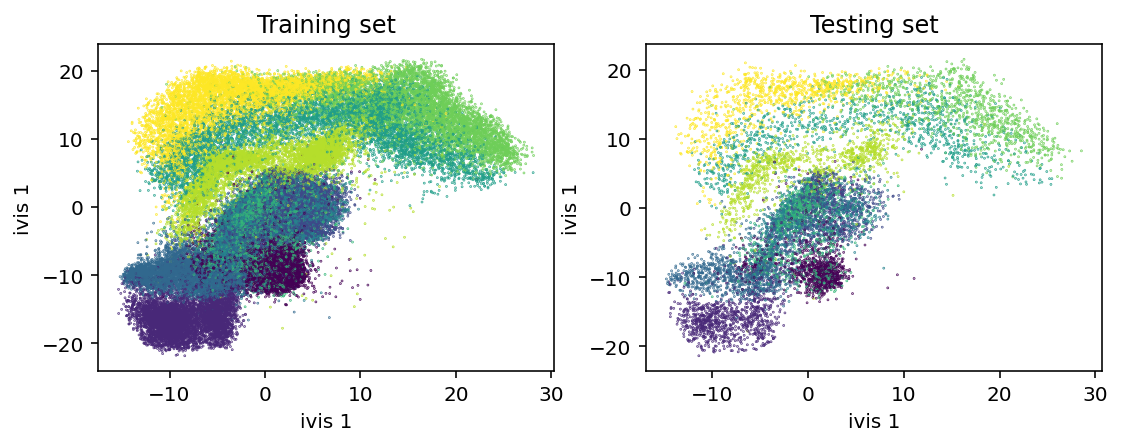

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))

axs[0].scatter(embeddings_train[:, 0], embeddings_train[:, 1], c=y_train, s=0.1)
axs[0].set_xlabel('ivis 1')
axs[0].set_ylabel('ivis 1')
axs[0].set_title('Training set')

axs[1].scatter(embeddings_test[:, 0], embeddings_test[:, 1], c=y_test, s=0.1)
axs[1].set_xlabel('ivis 1')
axs[1].set_ylabel('ivis 1')
axs[1].set_title('Testing set')